# <b>Deep learning to classify American Sign Language (ASL)

## <b>Our problem

The problem we are tackling is classifying American Sign Language Gestures into the respective letters they correspond to in the English Alphabet. To achieve this, we use will supervised learning on labelled images of ASL hand gestures. Our goal is to be able to make a model that can translate the gestures irrespective of the "background" or specific characteristics of the hand pictured.
    

## Contents 

  * ### Processing the Datasets - Dataset 1, Dataset 2 
  * ### Training on Dataset 1
      * #### Deep Learning from Scratch
      * #### Transfer Learning using VGG16
      * #### Testing on Dataset 2 
      

First we import neccessary libraries

In [1]:
import os
import cv2
import numpy as np
from time import time
import tensorflow as tf
import pandas as pd
import tensorflow.keras.models as km
import numpy as np
import PIL 
from PIL import Image
import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from to_import import *
%matplotlib inline


## Processing the Datasets 

We have decided to use two datasets to test the generalizability of our model, since that is the most important metric in this problem. The two datasets contain pictures of the ASL alphabet taken in two different contexts. This will be obvious when visualizing the data below. We will preprocees the data in the same way, and add augmentation when trying to avoid overfitting during our experiments below.

### Dataset 1

Here's a representation to give you an idea of what our data looks like.

In [2]:
from to_import import visualize
train_dir = '../asl_alphabet_train/asl_alphabet_train'


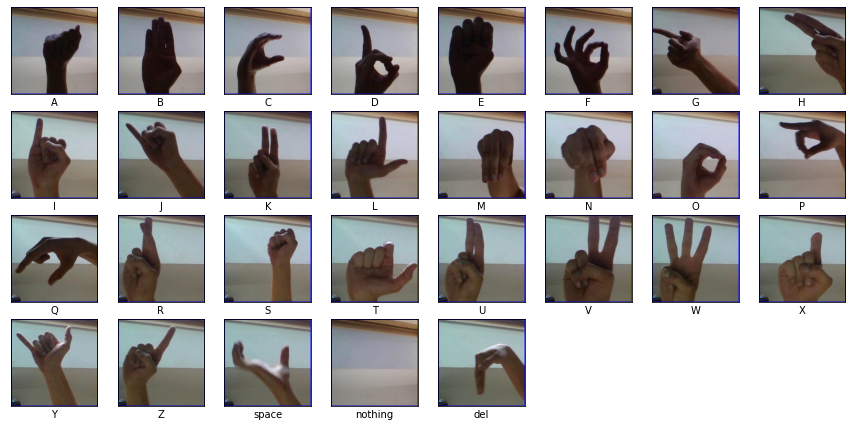

In [3]:
visualize(train_dir)

We extract our data, and split it into training and testing subsets, in order to check for accuracy in pictures never seen before by the model. In addition, we see the size of our dataset below. 

In [4]:
from to_import import load_data,split_data
# split_data(train_dir)
x_train, x_test, y_train, y_test = load_data(train_dir)

Loaded 78300 images for training, Train data shape = (78300, 64, 64, 3)
Loaded 8700 images for testing Test data shape = (8700, 64, 64, 3)


### Dataset 2

We follow the same procedure for the Second Dataset. It is clear that this datset is much smaller, but seems to have more diverse "backgrounds" that the hand finds itself in. This makes it a much harder learning problem. 

In [8]:
from to_import import visualize
train_dir2 = '../archive-2'

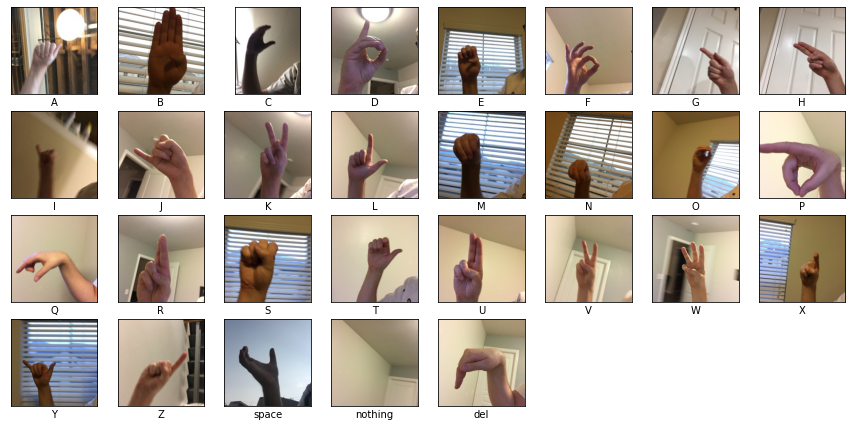

In [12]:

visualize(train_dir2)

In [9]:
x2_train, x2_test, y2_train, y2_test = load_data(train_dir2)

Loaded 783 images for training, Train data shape = (783, 64, 64, 3)
Loaded 87 images for testing Test data shape = (87, 64, 64, 3)


## Model from scratch

Since this task is somewhat similar to that of project 5, we decided to start with our scratch model from project 5 and do some hyperparameter tuning to get the best model.

In [12]:
from to_import import modelArch
model = modelArch()
rms = keras.optimizers.RMSprop(lr=8E-4)
model.compile(optimizer = rms , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4

In [127]:
history = model.fit(x_train, y_train, batch_size=32, epochs=11, validation_split=0.1, shuffle = True, verbose=0)

## <b>The results of our model<b>

The following section shows the result of our model and 2 graphs to show the change of the loss and accuracy over time

In [128]:
from to_import import accuracy, lossPlotter, accPlotter
import pylab as py
predictions = (model.predict(x_test) > 0.5).astype("int32")
accuracy(y_test, predictions)


97.45654938533276 %


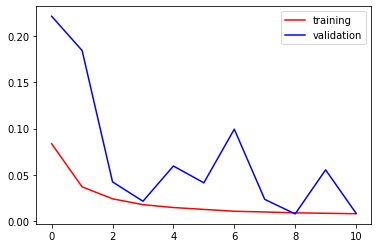

In [129]:
lossPlotter(history)

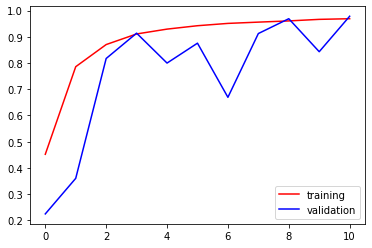

In [130]:
accPlotter(history)

## <b>The following section explains the choices of our parameters<b>

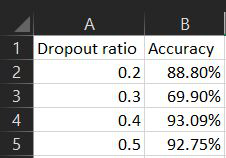

In [131]:
tuning = Image.open("Dropout.JPG")
tuning


This suggests that 0.4 is the best dropout ratio. This is important, because it shows that the model is wuickly overfitting to the dataset we have provided. This initial result suggests that using more data could be helpful in this problem. 

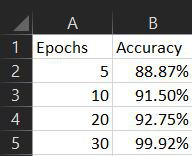

In [132]:
epochs = Image.open("epochs.JPG")
epochs

That would suggest that <b>30</b> epochs is the best; however, since we have a graph of the loss overtime, its clear that after the <b>12th</b> epoch there's a lot of overfitting happening which means that <b>12</b> epochs would best suit our model more, given our small batch size (32). The following graph shows that.

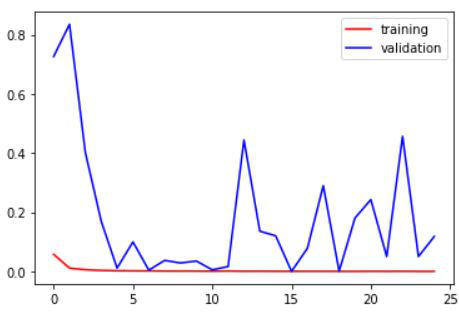

In [133]:
graph = Image.open("graph.JPG")
graph

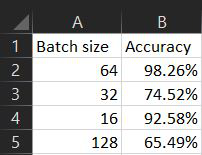

In [134]:
batch = Image.open("batch.JPG")
batch

We now want to make sure that this is the optimal batch size for our setup. We see that 64 is the ideal batch size given our previous decisions above. 

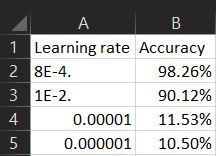

In [135]:
lr = Image.open("lr.JPG")
lr

So far we are getting a really good accuracy ranging from 88% to 98.5% with differnet parameters; however, we have an issure of overfitting that we can tell from the loss graph; this issue will lead to a lot less accuracy if we try our model on different data set than the one that we have. We are going to solve this issue in the next section.

# <b> Resolving overfitting

We have noticed that no matter how accurate our model is, there's always a problem of overfitting. This is obvious when looking at the loss graph. The plotted validation loss is much noisier than the training loss, and we can see that the trend even starts increasing by the last epochs. This means that trying to transfer this trained model to a different dataset our model will be much less accurate. We try to tackle this issue by usig 2 tecnhiques to resolve that issue; earlystopping and data augmentation.

## <b> Earlystopping

In [164]:
es = EarlyStopping(monitor ='val_loss', min_delta=0.001, patience=50)
history = model.fit(x_train, y_train, batch_size=32, epochs=11, validation_split=0.1, shuffle = True, callbacks = [es], verbose=0)

In [165]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
accuracy(y_test, predictions)

96.48155998304367 %


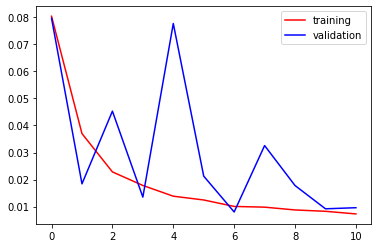

In [166]:
lossPlotter(history)

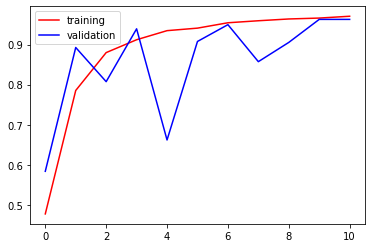

In [167]:
accPlotter(history)

## <b>Data Augmentation</b>

Early stopping didn't seem to really help with our issue, so we tried one more technique to overcome this problem which is data augmentation. Data augmentation will help us have much more data to train with and accordingly make our model adapt to different data set and have less overfitting.

### Augmentation we try:

* Horizontal flip
* Vertical flip
* Rotation
* Width shift
* Height shift

In [148]:
datagen = ImageDataGenerator(
    rotation_range=45, 
    width_shift_range=0.2,
    height_shift_range=0.2, 
    horizontal_flip=True,
    vertical_flip=False)
datagen.fit(x_train)


In [150]:
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_split=0.1, shuffle = True, verbose=0)

In [151]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
accuracy(y_test, predictions)


98.34675710046629 %


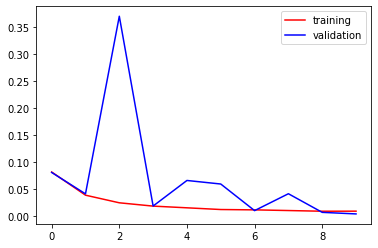

In [152]:
lossPlotter(history)

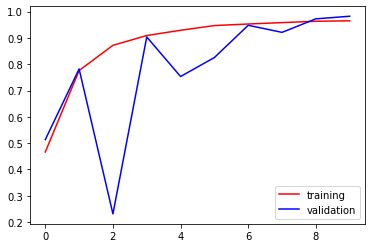

In [153]:
accPlotter(history)

### <b> Explaining our data augmentation parameters choices

* Rotation range: It makes sense that we don't need the image to be rotated by more than 45 deegree. In any data set it makes sense that the photo will be taken upright and there might be a little rotation to the right or the left, but there's no way that somebody will rotate their hand 90 degree while using a sign language. We are a little cautious when using the rotation since there are letters that resemble each other when rotated (for example I and J). However, we don't see a big effect of this type of 'confusion' in our report. 
    
* Horizontal flip: Since not everybody's dominant hand is right, a lot of different dataset might include left-handed sign language which would be the same thing but horizontally flipped. That's why we had our horizontal flip set as true to make sure that our model will work on left-handed people.

* Vertical flip: It doesn't make sense that anybody would flip their hand upside down before they do a sign and that's why we set that to  false.

* Width and height shift range: Different backgrounds and environments might lead to a shift in the width and height so we set that to be 0.2 to make sure it's not too big so we don't lose anything from the sign.


## <b> Concluding our scratch model
    
As we can see from the hyperparameters tuning, data augmentation, and different things that we have tried so far, some parameters got us really high accuracies but with a big problem of over fitting, which implies that we needed more data set to resolve that problem or different dataset would get much less accuracy. In this project we used data augmentation which seems to really help. However, the real test is testing on a completely different dataset. 

## Transfer Learning with VGG16

We now use transfer learning to tackle the learning problem of translating ASL to text. First, we try the VGG16 model which is popular for classification. Since it uses Visual Geometry we expect it to perform very well, and based on our learnings from project 5, we expect to not need more than 1 dense layer to classify our output. Our model training can be seen in out_vgg.txt. This first model is without data augmentation.


We choose the model with the highest accuracy. As we have this does not guarantee that our model is the best as there are significant changes of overfitting. The best model chosen has a small batch size (16) and runs for (30) epochs but has a small step size (1E-3). These hyperparameters suggest a lot of training based on our experience with project 5. While we know that this multi-class problem is harder, we cannot be sure of the extent of that increased difficulty, and whether this many iterations are necessary, or just increase the effect of overfitting. Our experiments show that adam is the optimal optimizer, which is consistent with the previous project. 

In [16]:
model = km.load_model("VGG-MODELS/VGG16_1Layer_lr-0.001000_BS-16_E-30_OPT-d.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_3 (Functional)    (None, 2048)              14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 29)                59421     
Total params: 14,774,109
Trainable params: 59,421
Non-trainable params: 14,714,688
_________________________________________________________________


We first check the accuracy onn our testing subset of Dataset 1. This seems impressive, but highly unrustworthy. 

In [17]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
accuracy(y_test, predictions)

99.7816091954023 %


('%s-pc', '99.7816091954023')

We also check the confusion matrix for our characters to check any unexpected correlations. As we expect based on the accuracy result, the confusion matrix shows all the letters accurately predicted.

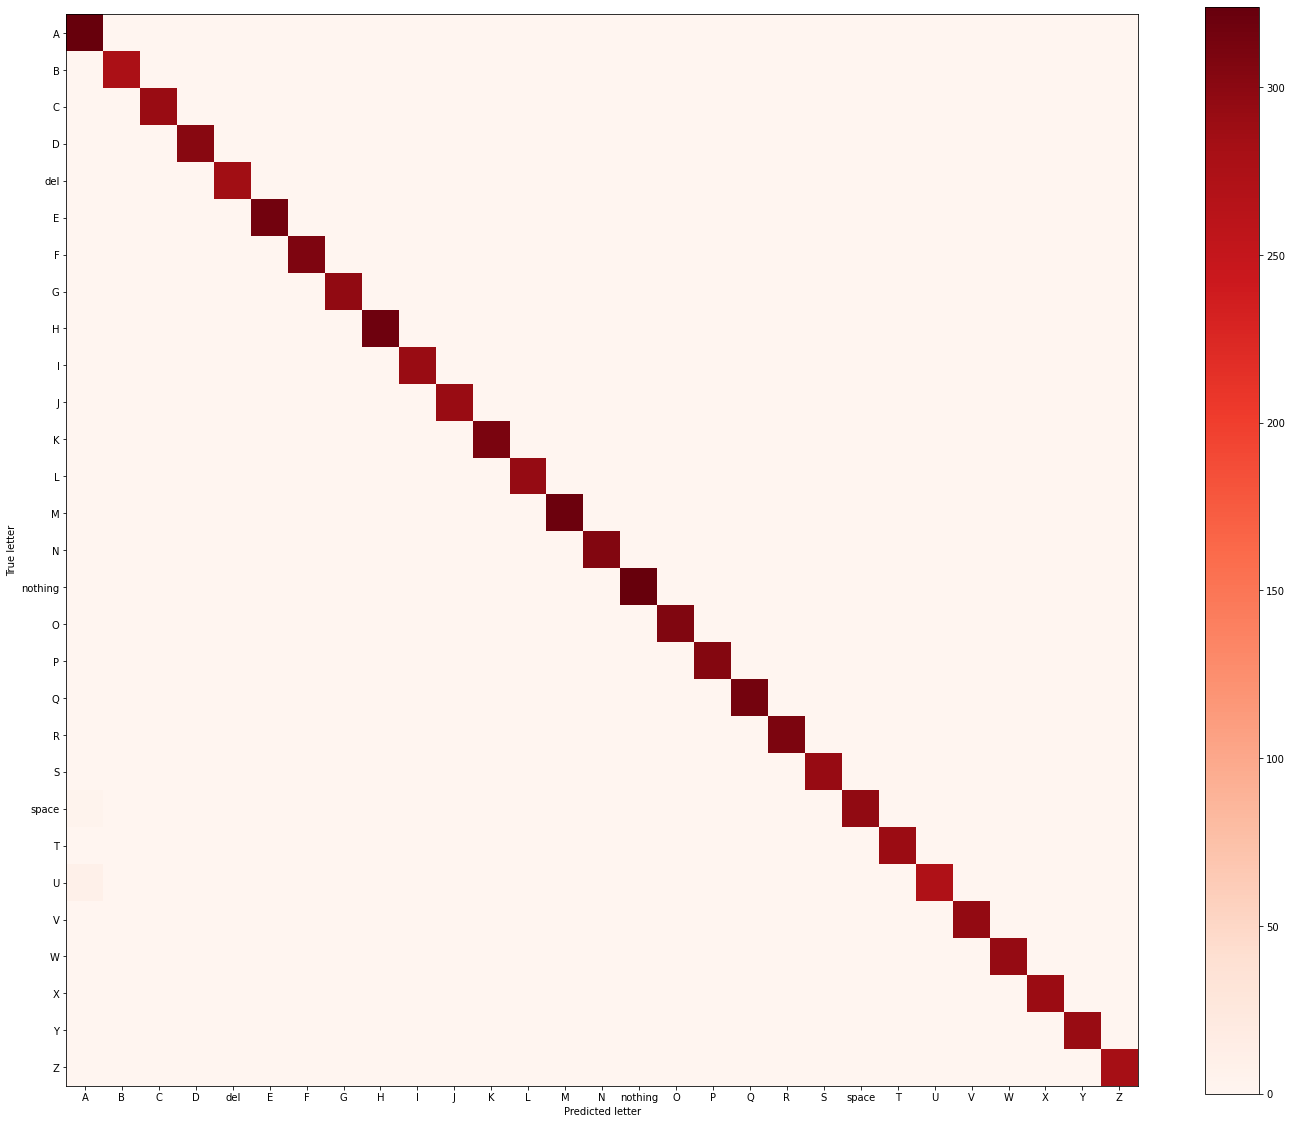

In [18]:
confusion_matrix(predictions,y_test,train_dir)

### Testing with Dataset 2 

At this point, we check how our model generalizes in a secondary degree. We test our model on the completely different second dataset. We will test our augmented data model from scratch, as well as from transfer learning.

In [9]:
x2_train, x2_test, y2_train, y2_test= load_data("../archive2")

Loaded 783 images for training, Train data shape = (783, 64, 64, 3)
Loaded 87 images for testing Test data shape = (87, 64, 64, 3)


##### From Scratch

In [10]:
model = km.load_model("Augmented_data_model")
predictions = (model.predict(x2_test) > 0.5).astype("int32")

In [41]:
accuracy(y2_test, predictions)

3.4482758620689653 %


('%s-pc', '3.4482758620689653')

While this accuracy seems terrible, it is to be expected. We have a very deep architecture, and the testig images "background", closely relate that of training. As a result, we try to generalize a little bit by making the architecture a little smaller. 

In [76]:
model = km.load_model("SCRATCH-MODELS/SCRATCH_AUG_less_lr-0.000010_BS-32_E-2_OPT-adam.h5")
predictions = (model.predict(x2_test) > 0.5).astype("int32")

In [77]:
accuracy(y2_test, predictions)

5.747126436781609 %


('%s-pc', '5.747126436781609')

We see that the accuracy is terrible, but we expected that overfitting was unnavoidable due to the nature of our data. The experiments in scratch_aug.txt show that the best accuracy we were able to produce was around 7 %. We remain optimistic when realizing that is still around 4 % higher than a random guys between 29 classes, which would be 3.44%. 

Visualizing the confusion matrix this time, we can see many unexpected correlations. It is interesting to note that the character I is the one most often predicted correctly. However, we can't necessarily get information from this matrix, since a lot of he values just seem random, such as a high correlation between W and del, that don't look alike. 

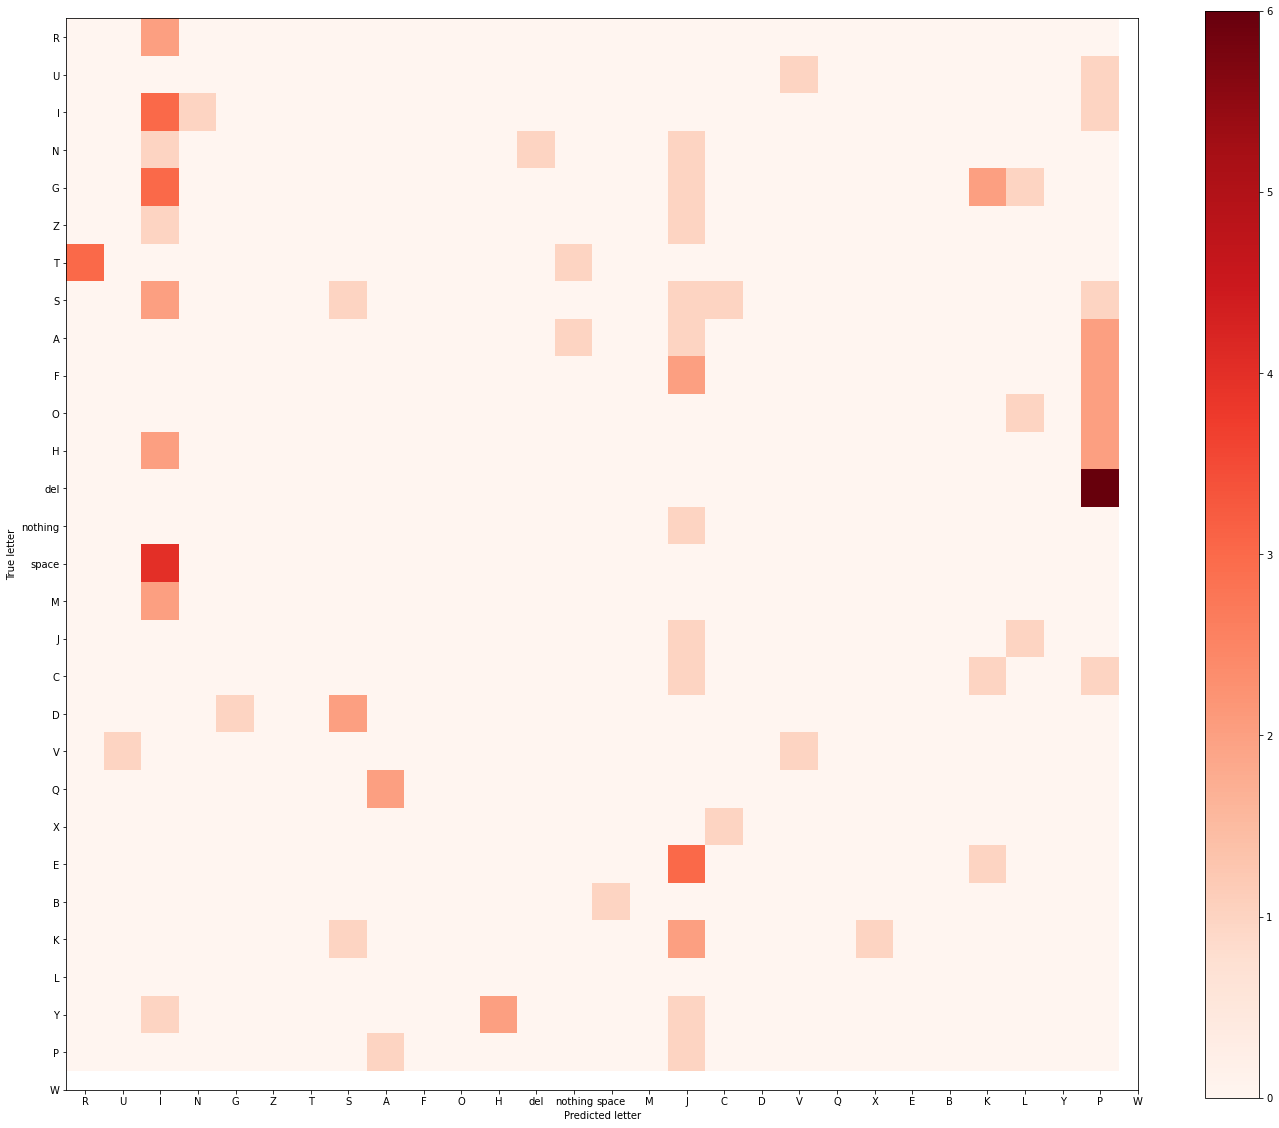

In [78]:
confusion_matrix(predictions,y2_test,train_dir2)

##### Using VGG16

In [95]:
model = km.load_model("VGG-MODELS/VGG16_1Layer_lr-0.010000_BS-64_E-2_OPT-a.h5")
predictions = (model.predict(x2_test) > 0.5).astype("int32")

In [96]:
accuracy(y2_test, predictions)

1.1494252873563218 %


('%s-pc', '1.1494252873563218')

We see that training the VGG model to generalize is much harder due to its deep architecture and the very little amount of data we have to fine-tune. 

Another idea that we can try is combine these two datasets in training and testing to see how our performance will change. While this seems like a good idea in theory, the datasets are extremely imbalanced in size and as a result we expect the model to overfit to the bigger dataset and ignore the smaller one. This is exactly demonstrated below, as we see the model is exactly "guessing" everytime a Dataset 2 image appears.


In [5]:
x_both_train, x_both_test,y_both_train,y_both_test, = load_data("both")

model = km.load_model("SCRATCH-MODELS/SCR_BOTH_lr-0.001000_BS-16_E-20_OPT-adam.h5")


In [10]:
print("Overall accuracy on combined test data set")
predictions = (model.predict(x_both_test) > 0.5).astype("int32")
accuracy(y_both_test, predictions)
print("Accuracy on Dataset 2 ")
predictions = (model.predict(x2_test) > 0.5).astype("int32")
accuracy(y2_test, predictions)
print("Accuracy on Dataset 1 ")
predictions = (model.predict(x_test) > 0.5).astype("int32")
accuracy(y_test, predictions)

Overall accuracy on combined test data set
98.40673722544668 %
Accuracy on Dataset 2 
3.4482758620689653 %
Accuracy on Dataset 1 
99.35632183908046 %


('%s-pc', '99.35632183908046')

## Conclusions 

#### 1. VGG16 is a robust model for complicated applications
We see that our assumptions that VGG16 would work well in classifying the data are correct. However, there is a tradeoff with overfitting the data when checking how it generalizes. 

#### 2. The lack of data is a major problem
We see that overfitting takes up almost entirely our analysis of the problems in training. The number of data points we have is not enough to generalize and be able to classify data extremely different than its own. This is an important learning experience for Deep Learning, as we see the extremely high need for labelled data around different tasks we take on automating. Finding datasets for this problem was somewha difficult as well, because most of the research on this problem is done on video data.

#### 3. Decreasing overfitting is therefore another big part of the research question. 
We see the increased performance when elimminating overfitting with mehods such as Data Augmentation. In the experiments testing with Dataset 2, we see an incredible rise in performance for the model from scratch from 0% accuracy to about 7%. Early stopping is another method we introduce, however it does not have significant results in this specific problem.

#### 4. It is important to pay attention to the data
There were misleading high accuracy numbers throughout this notebook, however when looking closely we often saw that there were masked problems. These included the model overfitting to one ype of data ad ignoring the other, or even overfitting to irrelevan features in one dataset. This makes us vigilant and cautious about our results.




